<center><h1>Haidar_Anastasia_HW6</h1></center>

Name: Anastasia Haidar
<br>
Github Username: haidarnastya
<br>
USC ID: 1163-9833-46

## 1. Tree-Based Methods

Import packages

In [29]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

### (a) Download the APS Failure data

In [2]:
#APS Failure at Scania Trucks
training_set = pd.read_csv('./data/aps_failure_training_set.csv', na_values='na', skiprows=20)
test_set = pd.read_csv('./data/aps_failure_test_set.csv', na_values='na', skiprows=20)

print("Train shape:", training_set.shape)
print("Test shape:", test_set.shape)
print(training_set.head())


Train shape: (60000, 171)
Test shape: (16000, 171)
  class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1   neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0     0.0   
2   neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3   neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4   neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0     0.0   

   ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006    ee_007  \
0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0  157956.0   
1     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   81140.0   
2     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0  158022.0   
3     0.0  ...      240.0      46.0      58.0      44.0      10.0       0.0   
4     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0  

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

The most common imputation strategy is median imputation, used for situations where features are numeric and have skewed distributions. We can also use mean imputation which is similar to median imputation, but is best for a more symmetric distribution. Another alternative is the KNN imputer which fills in the missingness based on similar neightbor samples, but it's not necessarily the best technique for situations with severe missingness since it's a slower technique. In comparing these methods, the best choice is likely the median imputation technique due to the high volume of missing data. 

#### (ii) Calculate the coefficient of variation

In [3]:
#For each of the 170 features, calculate the coefficient of variation CV = s/m,
#where s is sample standard deviation and m is sample mean.

#apply median imputation first
x_train = training_set.drop('class', axis=1)
y_train = training_set['class'].map({'neg': 0, 'pos':1})

x_test = test_set.drop('class', axis=1)
y_test = test_set['class'].map({'neg': 0, 'pos':1})

imputer = SimpleImputer(strategy='median')
x_train_imputed = imputer.fit_transform(x_train)
x_train_imputed = pd.DataFrame(x_train_imputed, columns=x_train.columns)
x_test_imputed = imputer.transform(x_test)
x_test_imputed = pd.DataFrame(x_test_imputed, columns=x_test.columns)

#find coefficient of variation for each feature
std = x_train_imputed.std()
mean = x_train_imputed.mean()

cv = std / mean.replace(0, np.nan)
cv = cv.replace([np.inf, -np.inf], np.nan).dropna()

#convert to cv df
cv_df = pd.DataFrame({'feature': cv.index, 'coefficient_of_variation': cv.values}).sort_values(by='coefficient_of_variation', ascending=False)
print(cv_df.head(10))


    feature  coefficient_of_variation
91   cf_000                244.887517
109  co_000                244.507385
3    ad_000                244.322816
122  cs_009                237.930554
136  dh_000                123.216097
138  dj_000                117.494225
6    ag_000                 92.917755
27   as_000                 87.332500
41   ay_009                 84.733735
19   ak_000                 80.424975


#### (iii) Plot a correlation matrix

          aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000  \
aa_000  1.000000  0.014085 -0.063876 -0.001590  0.043095  0.062855  0.018549   
ab_000  0.014085  1.000000 -0.002128 -0.000394  0.037572  0.053293 -0.000179   
ac_000 -0.063876 -0.002128  1.000000 -0.001765 -0.004250 -0.009480  0.017155   
ad_000 -0.001590 -0.000394 -0.001765  1.000000 -0.000168 -0.000209 -0.000043   
ae_000  0.043095  0.037572 -0.004250 -0.000168  1.000000  0.823123 -0.000445   
...          ...       ...       ...       ...       ...       ...       ...   
ee_007  0.603888  0.008520 -0.048648 -0.000801  0.035503  0.047858  0.000329   
ee_008  0.469836 -0.025599 -0.003714 -0.001235 -0.009632 -0.012347 -0.000787   
ee_009  0.247149 -0.016247  0.013764 -0.000716 -0.007218 -0.008996 -0.001209   
ef_000  0.012409  0.056271 -0.006262 -0.000082  0.070869  0.106312 -0.000078   
eg_000  0.024387  0.106360  0.014747 -0.000096  0.041725  0.060756  0.000236   

          ag_001    ag_002    ag_003  .

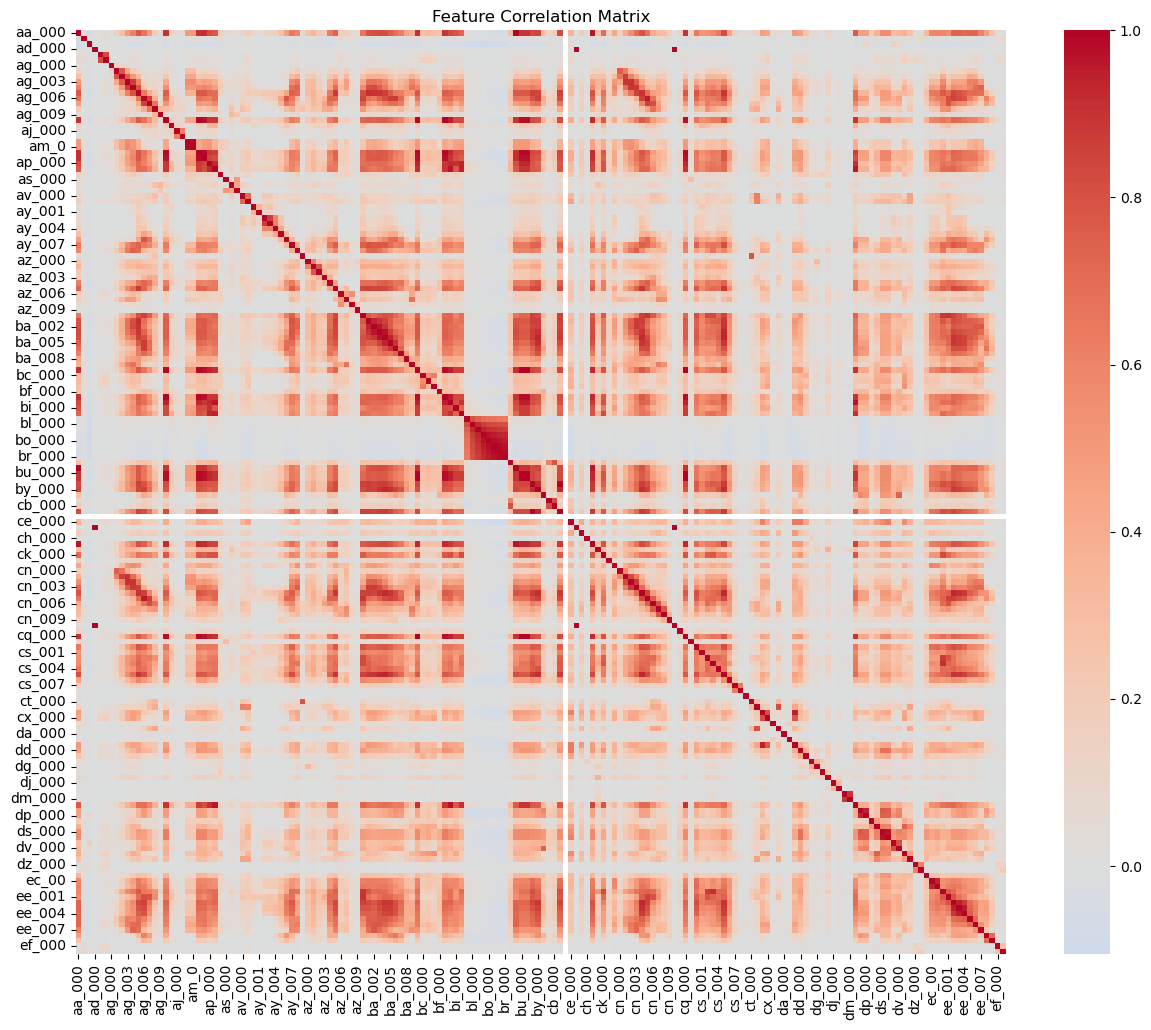

In [4]:
#Plot a correlation matrix for your features using pandas or any other tool.
cm = x_train_imputed.corr()
print(cm)

#plot as heatmap
plt.figure(figsize=(15,12))
sns.heatmap(cm, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

#### (iv) Make scatter plots and box plots

Top features by CV: ['cf_000', 'co_000', 'ad_000', 'cs_009', 'dh_000', 'dj_000', 'ag_000', 'as_000', 'ay_009', 'ak_000', 'az_009', 'ch_000', 'au_000']


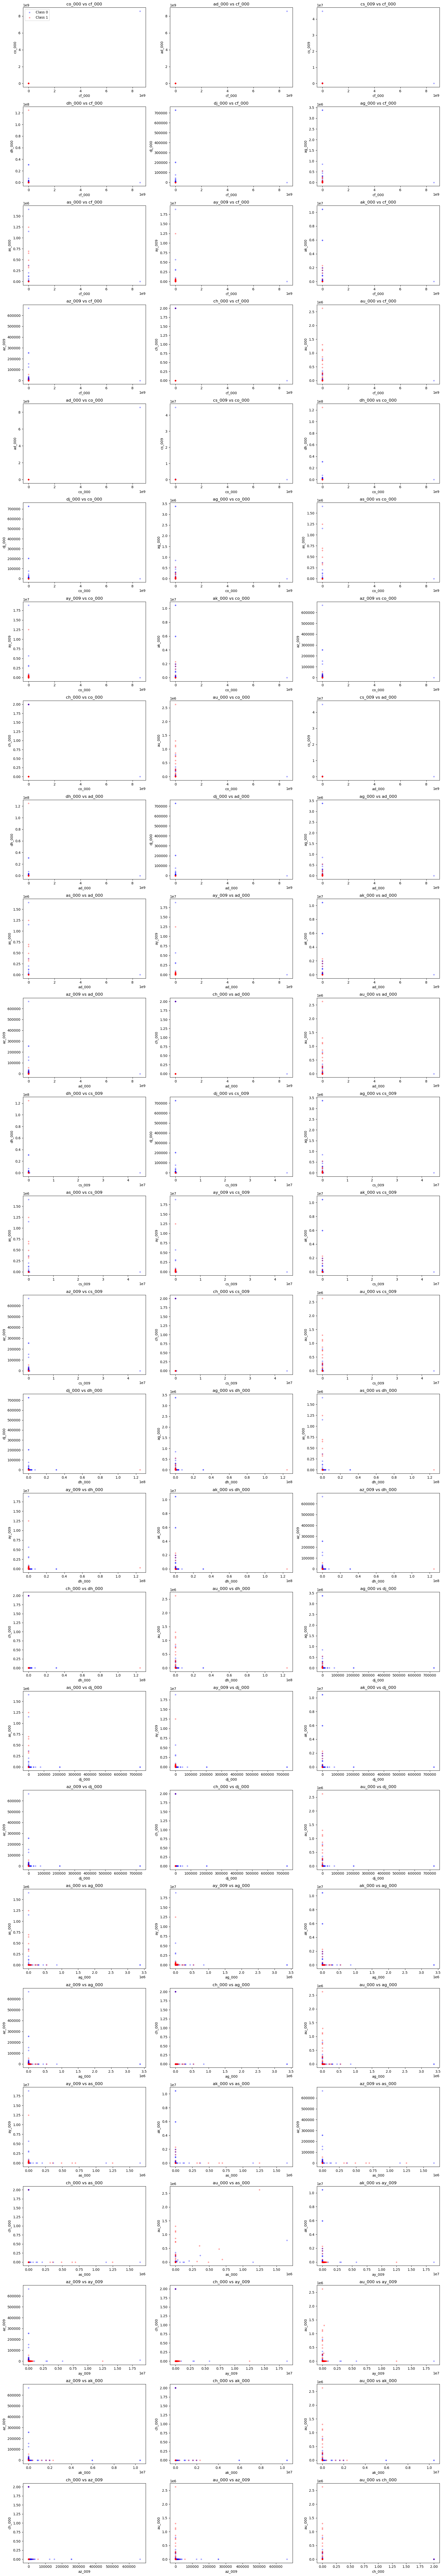

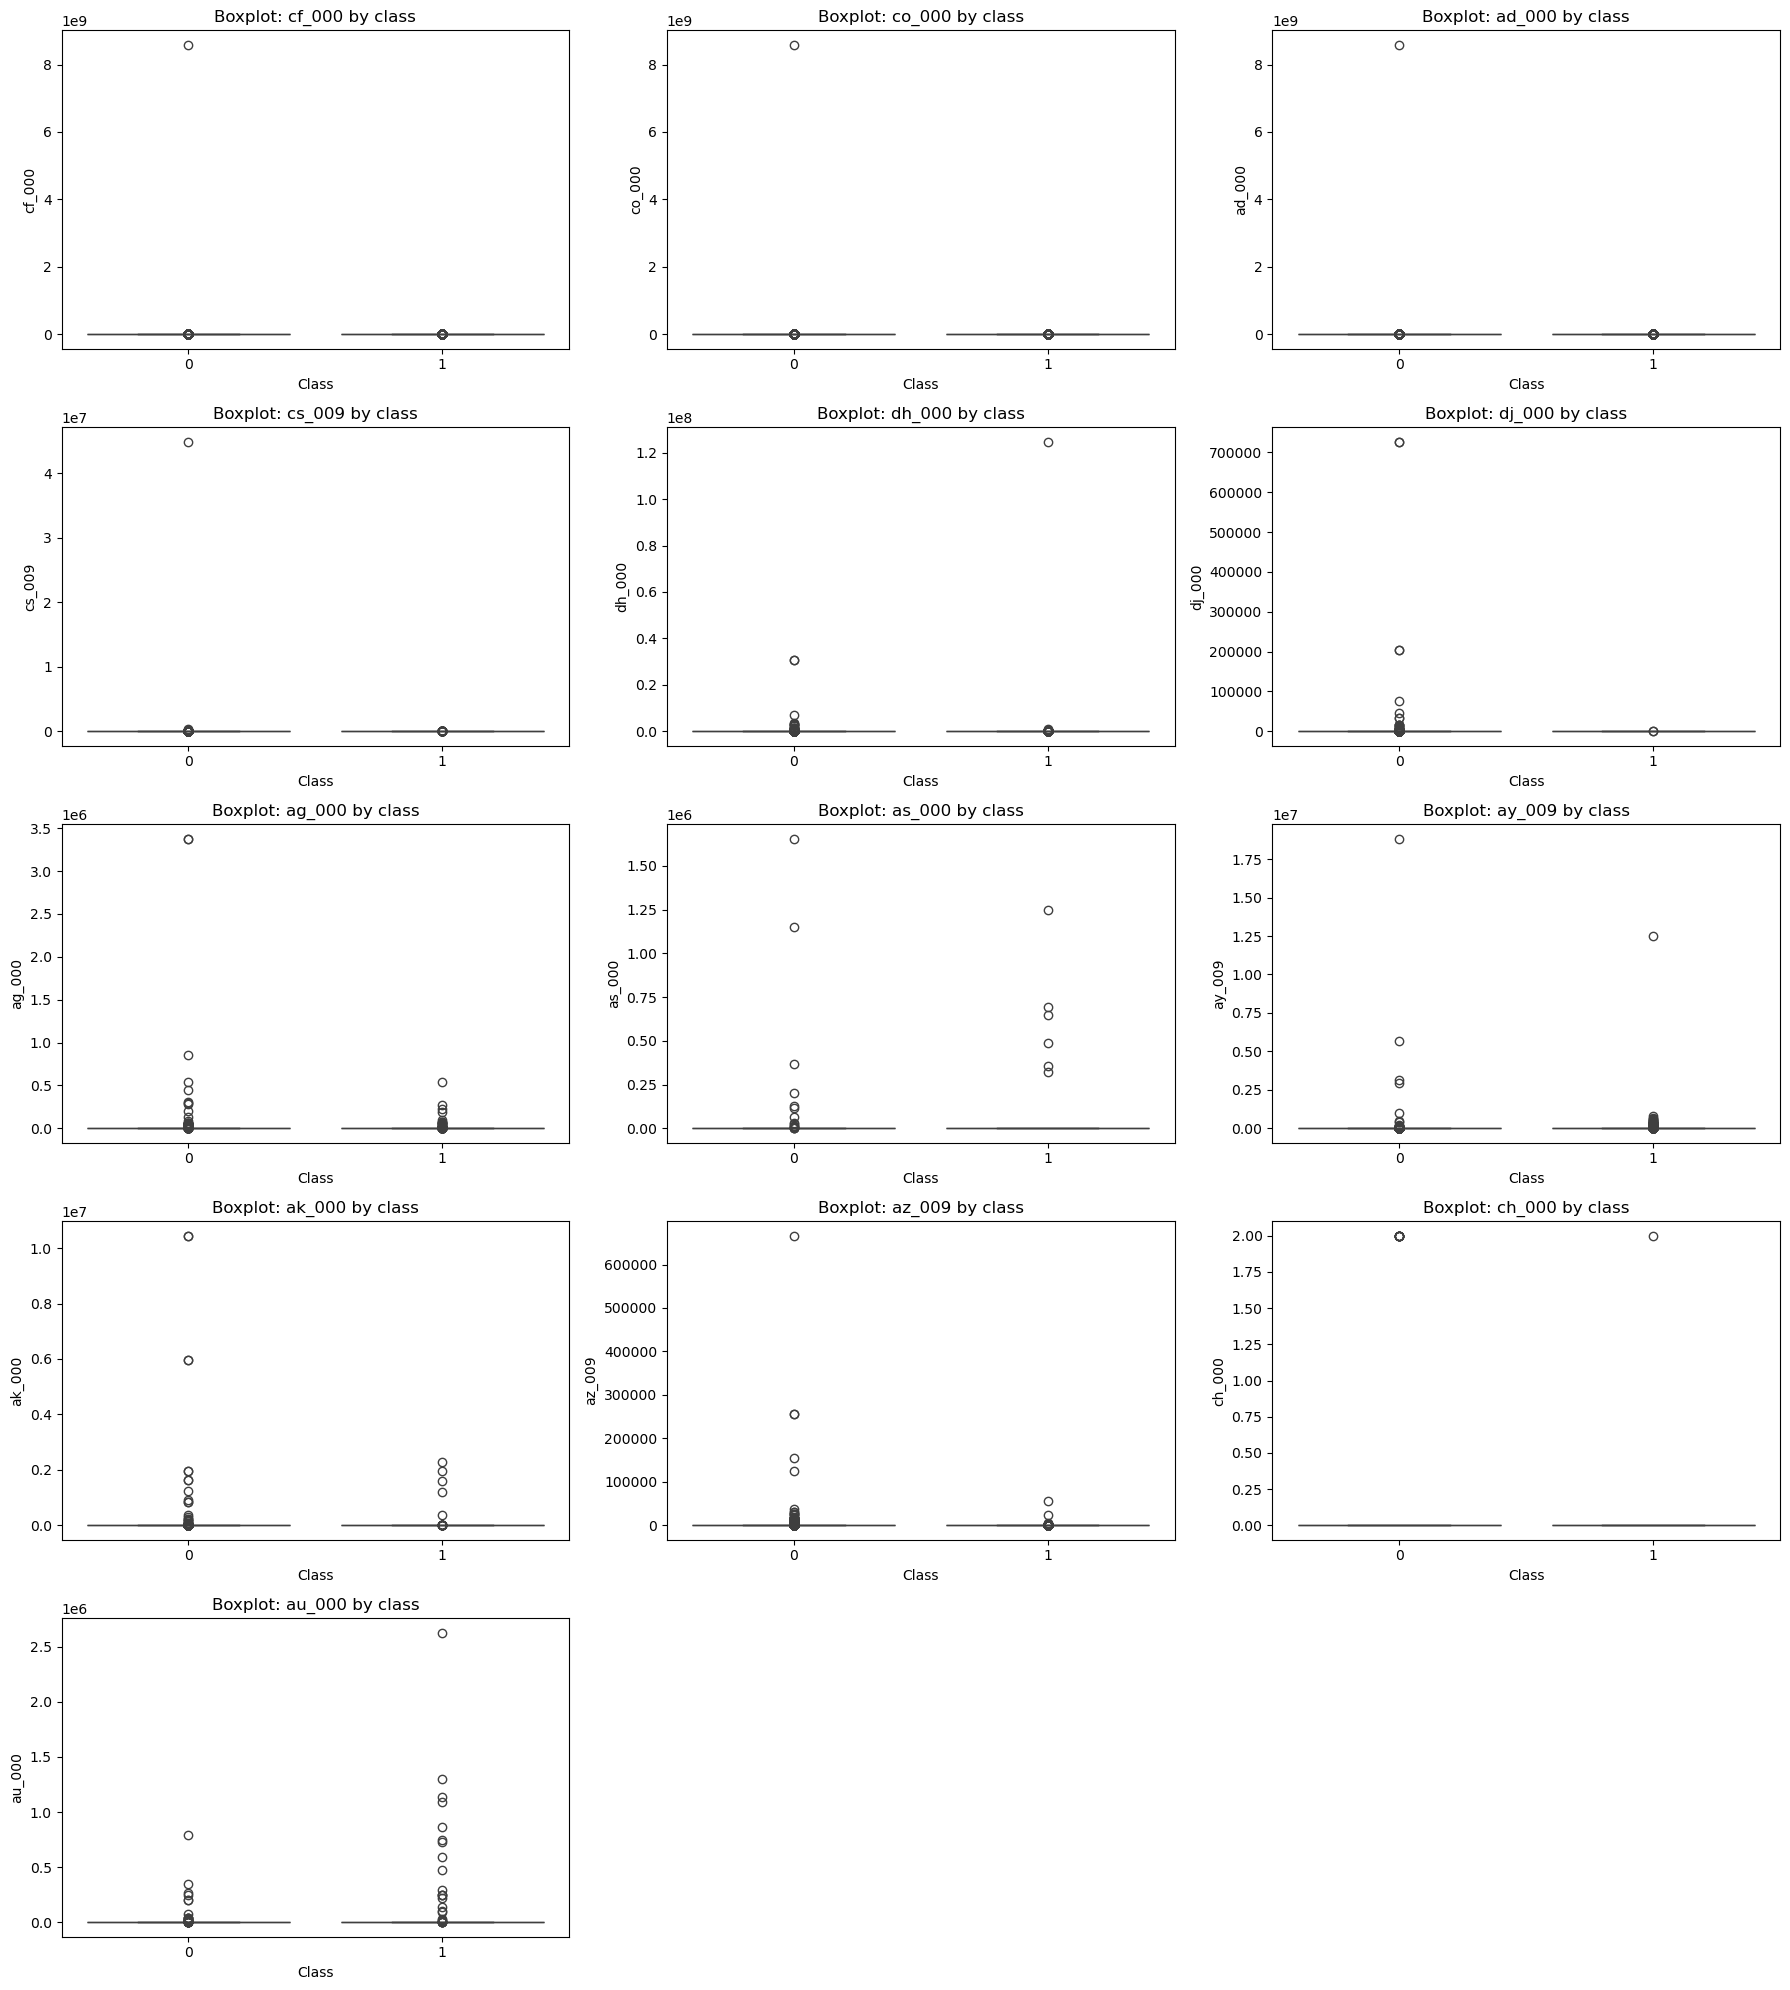

In [18]:
#Pick sqrt(170) features with highest CV , and make scatter plots and box plots
#for them, similar to those on p. 129 of ISLR. 
#Can you draw conclusions about significance of those features, just by the scatter plots? 
#This does not mean that you will only use those features in the following questions. 
#We picked them only for visualization.

#sqrt(170) ~13
top_features = int(np.sqrt(len(cv_df)))
top_feature_names = cv_df.head(top_features)['feature'].tolist()
print("Top features by CV:", top_feature_names)

x_top_features = x_train_imputed[top_feature_names]
y = y_train

#df for scatter plots
df_plots = x_top_features.copy()
df_plots['class'] = y.values

#scatter plots (feature pairs by class)
cols = 3
n_pairs = len(top_feature_names) * (len(top_feature_names) - 1) // 2
rows = math.ceil(n_pairs / cols)

plt.figure(figsize=(6*cols, 4*rows))
plot_idx = 1

for i in range(len(top_feature_names)):
    for j in range(i+1, len(top_feature_names)):
        plt.subplot(rows, cols, plot_idx)

        #plot class 0 as blue
        mask0 = df_plots['class'] == 0
        plt.scatter(df_plots.loc[mask0, top_feature_names[i]],
                    df_plots.loc[mask0, top_feature_names[j]],
                    alpha=0.3, s=10, c='blue', label='Class 0')

        #plot class 1 as red
        mask1 = df_plots['class'] == 1
        plt.scatter(df_plots.loc[mask1, top_feature_names[i]],
                    df_plots.loc[mask1, top_feature_names[j]],
                    alpha=0.3, s=10, c='red', label='Class 1')
        plt.xlabel(top_feature_names[i])
        plt.ylabel(top_feature_names[j])
        plt.title(f'{top_feature_names[j]} vs {top_feature_names[i]}')

        if plot_idx == 1:
            plt.legend()
        plot_idx += 1
plt.tight_layout()
plt.show()

#boxplots
cols = 3
rows = math.ceil(len(top_feature_names) / cols)

plt.figure(figsize = (6*cols, 4*rows))
for i, feature in enumerate(top_feature_names):
    plt.subplot(rows, cols, i+1)
    sns.boxplot(x='class', y=feature, data=df_plots)
    plt.title(f'Boxplot: {feature} by class')
    plt.xlabel('Class')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


Because of the high class imbalance and distribution of our features (mostly 0 values), the scatterplots are not informative about our data overall.  The box plots are more helpful, as they show whether the distribution of non-zero values differs between classes.

#### (v) Is this data set imbalanced?

In [20]:
#Determine the number of positive and negative data. 
#Is this data set imbalanced?

print('Class distribution in the training data:')
print(y_train.value_counts())

print("\nPercentages:")
print(y_train.value_counts(normalize=True)*100)

#Find ratios
negative_count = (y_train == 0).sum()
positive_count = (y_train == 1).sum()
ratio = negative_count / positive_count

print(f'Negative class (0)L {negative_count}')
print(f'Positive class (1): {positive_count}')
print(f'Imbalance Ratio: {ratio:.2f}:1')

if ratio > 1.5:
    print('Yes this data is imbalanced.')
    if ratio > 10:
        print('This dataset is SEVERELY imbalanced.')
else:
    print('This dataset is pretty balanced.')


Class distribution in the training data:
class
0    59000
1     1000
Name: count, dtype: int64

Percentages:
class
0    98.333333
1     1.666667
Name: proportion, dtype: float64
Negative class (0)L 59000
Positive class (1): 1000
Imbalance Ratio: 59.00:1
Yes this data is imbalanced.
This dataset is SEVERELY imbalanced.


### (c) Train a random forest

Confusion Matrix: Training
[[59000     0]
 [    1   999]]
Confusion Matrix: Test
[[15610    15]
 [  106   269]]

Misclassification Rate Training: 0.0000

Misclassification Rate Test: 0.0076


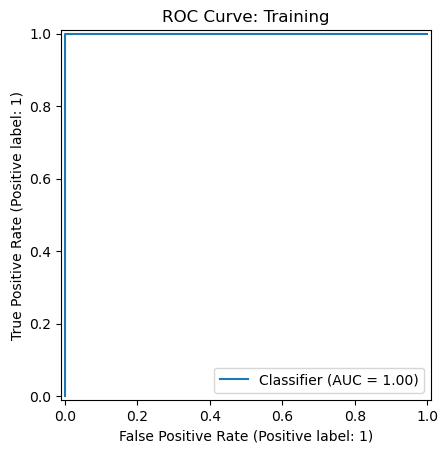

AUC Training: 1.0000


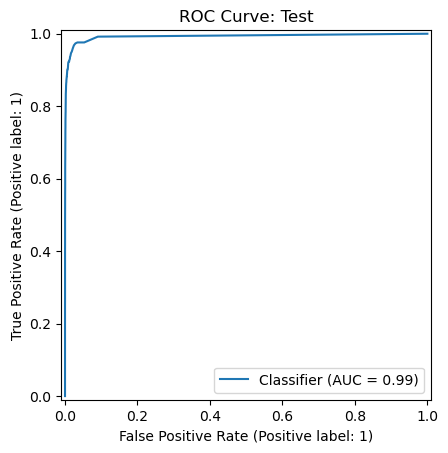

AUC Test: 0.9927
OOB Score: 0.9938
OOB Error: 0.0062
The Out of Bag Error is lower than the RandomForest Test error.


In [21]:
#create rf model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
rf_model.fit(x_train_imputed, y_train)

y_train_pred = rf_model.predict(x_train_imputed)
y_train_proba = rf_model.predict_proba(x_train_imputed)[:,1]

y_test_pred= rf_model.predict(x_test_imputed)
y_test_proba = rf_model.predict_proba(x_test_imputed)[:,1]

#evaluate model using confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC
#package).
#confusion matrix
print("Confusion Matrix: Training")
print(confusion_matrix(y_train, y_train_pred))

print("Confusion Matrix: Test")
print(confusion_matrix(y_test, y_test_pred))


#misclassification rate
train_misclass = 1 - accuracy_score(y_train, y_train_pred)
test_misclass = 1 - accuracy_score(y_test, y_test_pred)
print(f'\nMisclassification Rate Training: {train_misclass:.4f}')
print(f'\nMisclassification Rate Test: {test_misclass:.4f}')

#Training ROC
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title('ROC Curve: Training')
plt.show()
train_auc = roc_auc_score(y_train, y_train_proba)
print(f'AUC Training: {train_auc:.4f}')

#Test ROC
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve: Test')
plt.show()
test_auc = roc_auc_score(y_test, y_test_proba)
print(f'AUC Test: {test_auc:.4f}')

#Out of Bag Error (and compare to test error)
print(f'OOB Score: {rf_model.oob_score_:.4f}')
oob_error = 1 - rf_model.oob_score_
print(f'OOB Error: {oob_error:.4f}')

if oob_error < test_misclass:
    print('The Out of Bag Error is lower than the RandomForest Test error.')
elif oob_error > test_misclass:
    print('The RandomForest Test error is lower than the Out of Bag Error.')
else: 
    print('The errors are equal.')
    

### (d) Research class imbalance in random forest

Some techniques for class imbalance in a random forest including bagging - this involves bootstrapping techniques or undersampling. You can also use class weighting for bootstraping to assign weights to data based on class distribution, allowing to improve on minority class sample classification accuracy. RandomForestClassifier in Python has a built in option for indicating balanced class weight(class_weight=balanced). Python has a library called imblearn to either over or undersample the data. And finally, SMOTE can be used to generate synthetic samples of the minority classes.
Confusion Matrix: Training
[[59000     0]
 [    1   999]]
Confusion Matrix: Test
[[15612    13]
 [  159   216]]

Misclassification Rate Training: 0.0000

Misclassification Rate Test: 0.0108


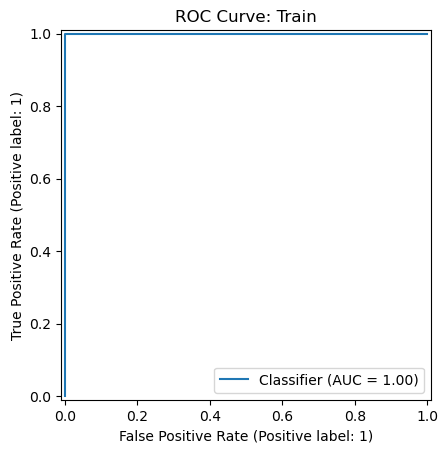

AUC Test: 1.0000


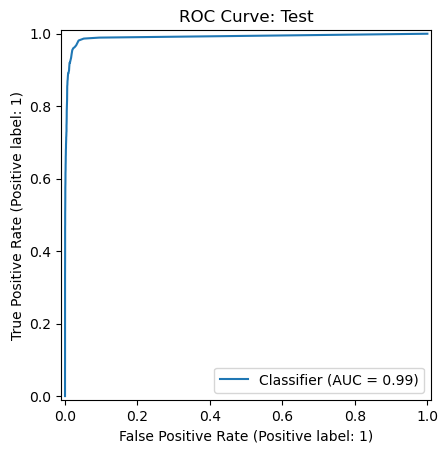

AUC Test: 0.9907
OOB Score: 0.9921
OOB Error: 0.0079
The Out of Bag Error is lower than the RandomForest Test error.


In [22]:
#Research how class imbalance is addressed in random forests. 
#Compensate for class imbalance in your random forest and repeat 1c. 
#Compare the results with those of 1c.
#https://www.geeksforgeeks.org/machine-learning/bagging-and-random-forest-for-imbalanced-classification/

print('Some techniques for class imbalance in a random forest including bagging - this involves bootstrapping techniques or undersampling. You can also use class weighting for bootstraping to assign weights to data based on class distribution, allowing to improve on minority class sample classification accuracy. RandomForestClassifier in Python has a built in option for indicating balanced class weight(class_weight=balanced). Python has a library called imblearn to either over or undersample the data. And finally, SMOTE can be used to generate synthetic samples of the minority classes.')

#We are going to use the built in class imbalance method for RandomForestClassifier first
rf_balanced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, class_weight='balanced_subsample')
rf_balanced.fit(x_train_imputed, y_train)

y_train_bal_pred = rf_balanced.predict(x_train_imputed)
y_train_bal_proba = rf_balanced.predict_proba(x_train_imputed)[:,1]

y_test_bal_pred= rf_balanced.predict(x_test_imputed)
y_test_bal_proba = rf_balanced.predict_proba(x_test_imputed)[:,1]

#evaluate model using confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC
#package).
#confusion matrix
print("Confusion Matrix: Training")
print(confusion_matrix(y_train, y_train_bal_pred))
print("Confusion Matrix: Test")
print(confusion_matrix(y_test, y_test_bal_pred))

#misclassification rate
train_bal_misclass = 1 - accuracy_score(y_train, y_train_bal_pred)
print(f'\nMisclassification Rate Training: {train_bal_misclass:.4f}')
test_bal_misclass = 1 - accuracy_score(y_test, y_test_bal_pred)
print(f'\nMisclassification Rate Test: {test_bal_misclass:.4f}')

#Training ROC
RocCurveDisplay.from_predictions(y_train, y_train_bal_proba)
plt.title('ROC Curve: Train')
plt.show()
train_auc_bal = roc_auc_score(y_train, y_train_bal_proba)
print(f'AUC Test: {train_auc_bal:.4f}')

#Test ROC
RocCurveDisplay.from_predictions(y_test, y_test_bal_proba)
plt.title('ROC Curve: Test')
plt.show()
test_auc_bal = roc_auc_score(y_test, y_test_bal_proba)
print(f'AUC Test: {test_auc_bal:.4f}')

#Out of Bag Error (and compare to test error)
print(f'OOB Score: {rf_balanced.oob_score_:.4f}')
oob_bal_error = 1 - rf_balanced.oob_score_
print(f'OOB Error: {oob_bal_error:.4f}')

#Comparison of OOB and Test Errors
if oob_bal_error < test_bal_misclass:
    print('The Out of Bag Error is lower than the RandomForest Test error.')
elif oob_bal_error > test_bal_misclass:
    print('The RandomForest Test error is lower than the Out of Bag Error.')
else: 
    print('The errors are equal.')


### (e) XGBoost and Model Trees

Finding best lambda..
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best lambda: 2.0
Mean CV Error: 0.011375974576271153
Confusion Matrix: Training [[58941    59]
 [  223   777]]
Training Error: 0.0047000000000000375
Training AUC: 0.9953878220338983


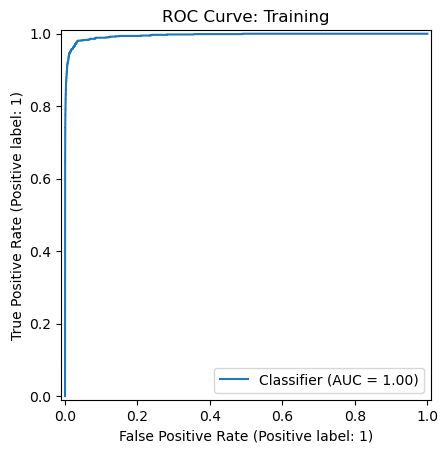

Confusion Matrix: Test [[15598    27]
 [  117   258]]
Test Error: 0.009000000000000008
Test AUC: 0.9956867413333333


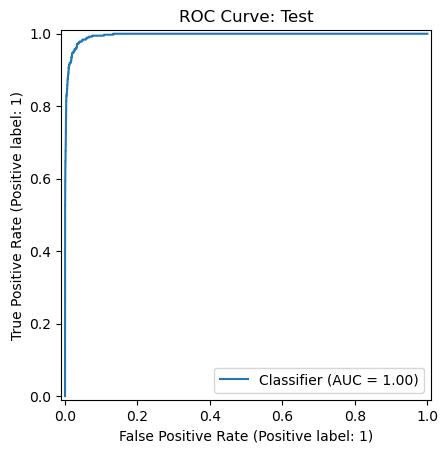

##################################
The CV error is a good estimate of test error.


In [ ]:
###XGBOOST WITH L1 PENALIZED LOGISTIC REGRESSION###
#Determine lambda using cross validation

#define parameters for lambda
params = {'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

#buildxgboost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=42)

#5 fold Cross validation to find best lambda
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

print('Finding best lambda..')
grid_search.fit(x_train_imputed, y_train)
print('Best lambda:', grid_search.best_params_['reg_alpha'])

#train XGBoost model with best lambda
best_lambda = grid_search.best_params_['reg_alpha']
xgb_final = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=3, learning_rate=0.1, reg_alpha=best_lambda, eval_metric='logloss', random_state=42)
xgb_final.fit(x_train_imputed, y_train)

#get CV error using trained model
cv_scores = cross_val_score(xgb_final, x_train_imputed, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_err = 1 - cv_scores.mean()
print('Mean CV Error:', cv_err)

#Evaluate on training set
y_train_pred = xgb_final.predict(x_train_imputed)
y_train_proba = xgb_final.predict_proba(x_train_imputed)[:,1]

print('Confusion Matrix: Training', confusion_matrix(y_train, y_train_pred))
train_err = 1 - accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
print('Training Error:', train_err)
print('Training AUC:', train_auc)

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title('ROC Curve: Training')
plt.show()

#Evaluate on test set
y_test_pred = xgb_final.predict(x_test_imputed)
y_test_proba = xgb_final.predict_proba(x_test_imputed)[:,1]

print('Confusion Matrix: Test', confusion_matrix(y_test, y_test_pred))
test_err = 1 - accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)
print('Test Error:', test_err)
print('Test AUC:', test_auc)

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title('ROC Curve: Test')
plt.show()

###COMPARE CV AND TEST ERRORS###
print('##################################')
if abs(cv_err - test_err) < 0.01:
    print('The CV error is a good estimate of test error.')
elif cv_error < test_error:
    print('The CV error is less than the test error.')
else:
    print('The CV error is greater than the test error.')


### (f) Use SMOTE to pre-process your data

UNCOMPENSATED XGBOOST
Average CV AUC: 0.9880
Confusion Matrix: Training [[58938    62]
 [  224   776]]
Training Error: 0.004766666666666697
Training AUC: 0.9955794830508474
Confusion Matrix: Test [[15603    22]
 [  112   263]]
Test Error: 0.008375000000000021
Test AUC: 0.9957259946666667


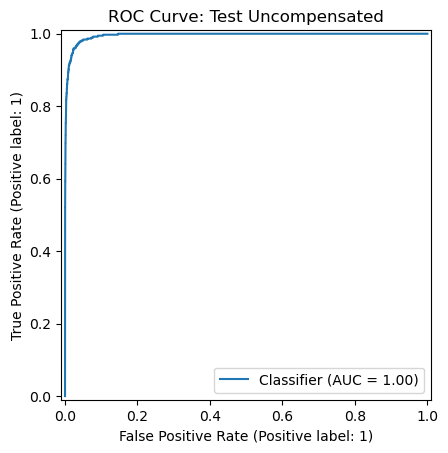

XGBOOST WITH SMOTE (COMPENSATED)
Average CV AUC scores with SMOTE 0.9843384745762712
Original dataset: 60000
After SMOTE: 118000
Confusion Matrix: Training
[[57820  1180]
 [   69   931]]

Training Error: 0.0208
AUC Train: 0.9942
Confusion Matrix: Test
[[15335   290]
 [   28   347]]

Test Error: 0.0199
AUC Test: 0.9937


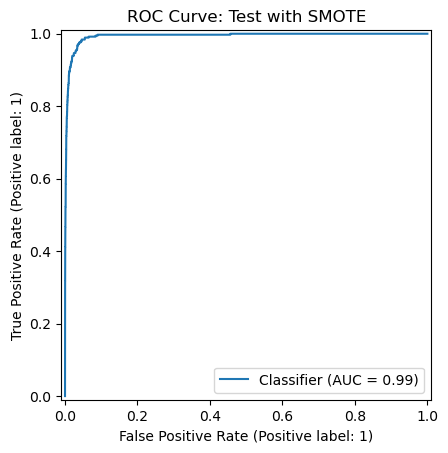

SMOTE vs UNCOMPENSATED COMPARISON
The uncompensated model test error is less than the test error of the SMOTE model.


In [ ]:
###UNCOMPENSATED XGBOOST (NO SMOTE)###
print("UNCOMPENSATED XGBOOST")
xgb_uncompensated = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=3, learning_rate=0.1, reg_alpha=1.0, eval_metric='logloss', random_state=42)
xgb_uncompensated.fit(x_train_imputed, y_train)

#cross validation
cv_uncomp =StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_uncomp = cross_val_score(xgb_uncompensated, x_train_imputed, y_train, cv=cv_uncomp, scoring='roc_auc', n_jobs=-1)
print(f'Average CV AUC: {cv_scores_uncomp.mean():.4f}')

#evaluate on training set
y_train_pred_uncomp = xgb_uncompensated.predict(x_train_imputed)
y_train_proba_uncomp = xgb_uncompensated.predict_proba(x_train_imputed)[:,1]

cm_train_uncomp = confusion_matrix(y_train, y_train_pred_uncomp)
print('Confusion Matrix: Training', cm_train_uncomp)

train_err_uncomp = 1 - accuracy_score(y_train, y_train_pred_uncomp)
train_auc_uncomp = roc_auc_score(y_train, y_train_proba_uncomp)
print('Training Error:', train_err_uncomp)
print('Training AUC:', train_auc_uncomp)

#evaluate on test set
y_test_pred_uncomp = xgb_uncompensated.predict(x_test_imputed)
y_test_proba_uncomp = xgb_uncompensated.predict_proba(x_test_imputed)[:,1]

cm_test_uncomp = confusion_matrix(y_test, y_test_pred_uncomp)
print('Confusion Matrix: Test', cm_test_uncomp)

test_err_uncomp = 1 - accuracy_score(y_test, y_test_pred_uncomp)
test_auc_uncomp = roc_auc_score(y_test, y_test_proba_uncomp)
print('Test Error:', test_err_uncomp)
print('Test AUC:', test_auc_uncomp)

RocCurveDisplay.from_predictions(y_test, y_test_proba_uncomp)
plt.title('ROC Curve: Test Uncompensated')
plt.show()

###COMPENSATED XGBOOST WITH SMOTE###
print("XGBOOST WITH SMOTE (COMPENSATED)")
#apply SMOTE for imbalanced dataset within each cv fold
smote_pipeline = ImbPipeline([('smote', SMOTE(random_state=42)), ('xgb', xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=3, learning_rate=0.1, reg_alpha=1.0, eval_metric='logloss', random_state=42))])

cv_scores_smote = cross_val_score(smote_pipeline, x_train_imputed, y_train, cv=cv_uncomp, scoring='roc_auc', n_jobs=-1)
print('Average CV AUC scores with SMOTE', cv_scores_smote.mean())

#final evaluate to full training set
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_train_imputed, y_train)

#check SMOTE dataset
print(f'Original dataset: {x_train_imputed.shape[0]}')
print(f'After SMOTE: {x_res.shape[0]}')

#final model on SMOTE data
xgb_smote = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=3, learning_rate=0.1, reg_alpha=1.0, eval_metric='logloss', random_state=42)
xgb_smote.fit(x_res, y_res)

#evaluate the training model
y_train_pred_smote = xgb_smote.predict(x_train_imputed)
y_train_proba_smote = xgb_smote.predict_proba(x_train_imputed)[:,1]

print("Confusion Matrix: Training")
print(confusion_matrix(y_train, y_train_pred_smote))

train_err_smote = 1 - accuracy_score(y_train, y_train_pred_smote)
print(f'\nTraining Error: {train_err_smote:.4f}')

train_auc = roc_auc_score(y_train, y_train_proba_smote)
print(f'AUC Train: {train_auc:.4f}')

#evaluate test model
y_test_pred_smote = xgb_smote.predict(x_test_imputed)
y_test_proba_smote = xgb_smote.predict_proba(x_test_imputed)[:,1]

print("Confusion Matrix: Test")
print(confusion_matrix(y_test, y_test_pred_smote))

test_err_smote = 1 - accuracy_score(y_test, y_test_pred_smote)
print(f'\nTest Error: {test_err_smote:.4f}')

test_auc_smote = roc_auc_score(y_test, y_test_proba_smote)
print(f'AUC Test: {test_auc_smote:.4f}')

RocCurveDisplay.from_predictions(y_test, y_test_proba_smote)
plt.title('ROC Curve: Test with SMOTE')
plt.show()

###COMPARE UNCOMPENSATED TO SMOTE###
print('SMOTE vs UNCOMPENSATED COMPARISON')
if test_err_uncomp < test_err_smote:
      print('The uncompensated model test error is less than the test error of the SMOTE model.')
elif test_err_uncomp > test_err_smote:
    print('The SMOTE model has a test error less than the uncompensated model.')
else:
     print('The test errors are the same for both the uncompensated and SMOTE models.')


###REFERENCES###

https://scikit-learn.org/stable/modules/impute.html

https://medium.com/@tarangds/a-comprehensive-guide-to-data-imputation-techniques-strategies-and-best-practices-152a10fee543

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

https://seaborn.pydata.org/generated/seaborn.heatmap.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

https://seaborn.pydata.org/generated/seaborn.boxplot.html

https://stackoverflow.com/questions/56974174/how-to-make-a-loop-for-multiple-scatterplots-in-python

https://www.geeksforgeeks.org/data-visualization/seaborn-plots-in-a-loop-efficient-data-visualization-techniques/

copilot: how to fix my scatter plot loop for feature pairs

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

https://www.geeksforgeeks.org/machine-learning/oob-errors-for-random-forests-in-scikit-learn/

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Copilot: my CV is taking a long time, how can i loop through specific ranges of alphas for faster run time? 

https://www.geeksforgeeks.org/machine-learning/smote-for-imbalanced-classification-with-python/

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://stackoverflow.com/questions/72368195/how-to-properly-use-smote-in-classification-models

Copilot: does smote run before cv or during? 